# Data Analysis-- Supervised Learning
* Created on 12/13/2023 by Jie Shi
* Modified from  Nov 22 2021 by Shangying Wang
* This code is used for prediction of the mean fold change from the overexpression of genes 
* __This code tested and finetuned both GBR and CNN+LSTM model__
* __data where genes are knocked out are removed__

In [3]:
%load_ext autoreload
%autoreload 2
from mylib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf 
import numpy as np 
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 
import csv 
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed, Reshape
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import scipy.stats
import pickle # for saving ML models 

In [6]:
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['xtick.major.size'] = 3
#plt.rcParams['xtick.major.width'] = 2
#plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.labelsize'] = 20
#plt.rcParams['ytick.major.width'] = 1
#plt.rcParams['ytick.minor.size'] = 5
#plt.rcParams['figure.figsize'] =  (30, 30)
plt.rcParams['axes.titlesize'] = 18

plt.rcParams['axes.labelsize'] = 20
#plt.rcParams['axes.labelsize'] = 16

plt.rcParams['axes.grid'] = False
# Resolution
# Legend Parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.fontsize'] = 16

# For peroxisome data analysis

## Load data from file

In [8]:
all_data=pd.read_csv('data/overexpressed_jb_update_05152023_nodup_final_round.csv',sep=',')
#all_data=pd.read_csv('../data/overexpressed_jb_update_05152023_nodup_new.csv',sep=',')
display(all_data)
#all_data.drop(['Case #', 'OE/KO test case average (Relative fluorescence units/ Optical density)', 
#               'OE/KO test case standard deviation', 'WT average (Relative fluorescence units/ Optical density)', 
#               'WT standard deviation'], axis=1, inplace=True)


all_data = all_data.drop(all_data.columns[0],axis = 1)
all_data = all_data.fillna(0)
display(all_data)

,Unnamed: 0,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,...,Pex30,Pex31,Pex32,Pex34,Sei1,Rtn1,Vps1,capacity_mean,capacity_std,capacity_instances
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.735,0.2192,"(0.89, 0.58)"
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.970,0.0000,"(0.97,)"
2,2,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.887,0.1100,"(0.78, 0.88, 1)"
3,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0.790,0.0000,"(0.79,)"
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.040,0.0000,"(1.04,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0.680,0.0000,0
196,196,1,0,0,0,0,0,0,1,1,...,1,1,0,1,1,1,0,0.480,0.0000,0
197,197,0,0,0,0,0,1,0,1,1,...,0,1,1,0,1,1,1,0.800,0.0000,0
198,198,0,0,1,1,0,0,1,0,0,...,1,0,0,1,0,1,1,0.710,0.0000,0


,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Pex30,Pex31,Pex32,Pex34,Sei1,Rtn1,Vps1,capacity_mean,capacity_std,capacity_instances
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.735,0.2192,"(0.89, 0.58)"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.970,0.0000,"(0.97,)"
2,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0.887,0.1100,"(0.78, 0.88, 1)"
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0.790,0.0000,"(0.79,)"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.040,0.0000,"(1.04,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0.680,0.0000,0
196,1,0,0,0,0,0,0,1,1,1,...,1,1,0,1,1,1,0,0.480,0.0000,0
197,0,0,0,0,0,1,0,1,1,0,...,0,1,1,0,1,1,1,0.800,0.0000,0
198,0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,1,1,0.710,0.0000,0


In [9]:
#data statistics
stats_df = all_data.describe()
stats_df

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Pex29,Pex30,Pex31,Pex32,Pex34,Sei1,Rtn1,Vps1,capacity_mean,capacity_std
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.310000,0.235000,0.305000,0.290000,0.460000,0.175000,0.21000,0.360000,0.275000,0.265000,...,0.390000,0.220000,0.220000,0.205000,0.320000,0.195000,0.250000,0.375000,1.064048,0.056621
std,0.463654,0.425063,0.461563,0.454901,0.499648,0.380921,0.40833,0.481205,0.447635,0.442441,...,0.488974,0.415286,0.415286,0.404715,0.467647,0.397195,0.434099,0.485338,0.331137,0.102260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.890000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.250000,1.000000,1.230000,0.090000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.550000,0.558600


In [10]:
field = "capacity_mean"
skew_vals1=all_data[field].skew()
skew_vals1

0.6143747279602101

In [11]:
skew_vals2=all_data[field].apply(np.log1p).skew()
skew_vals2

-0.2841992668228129

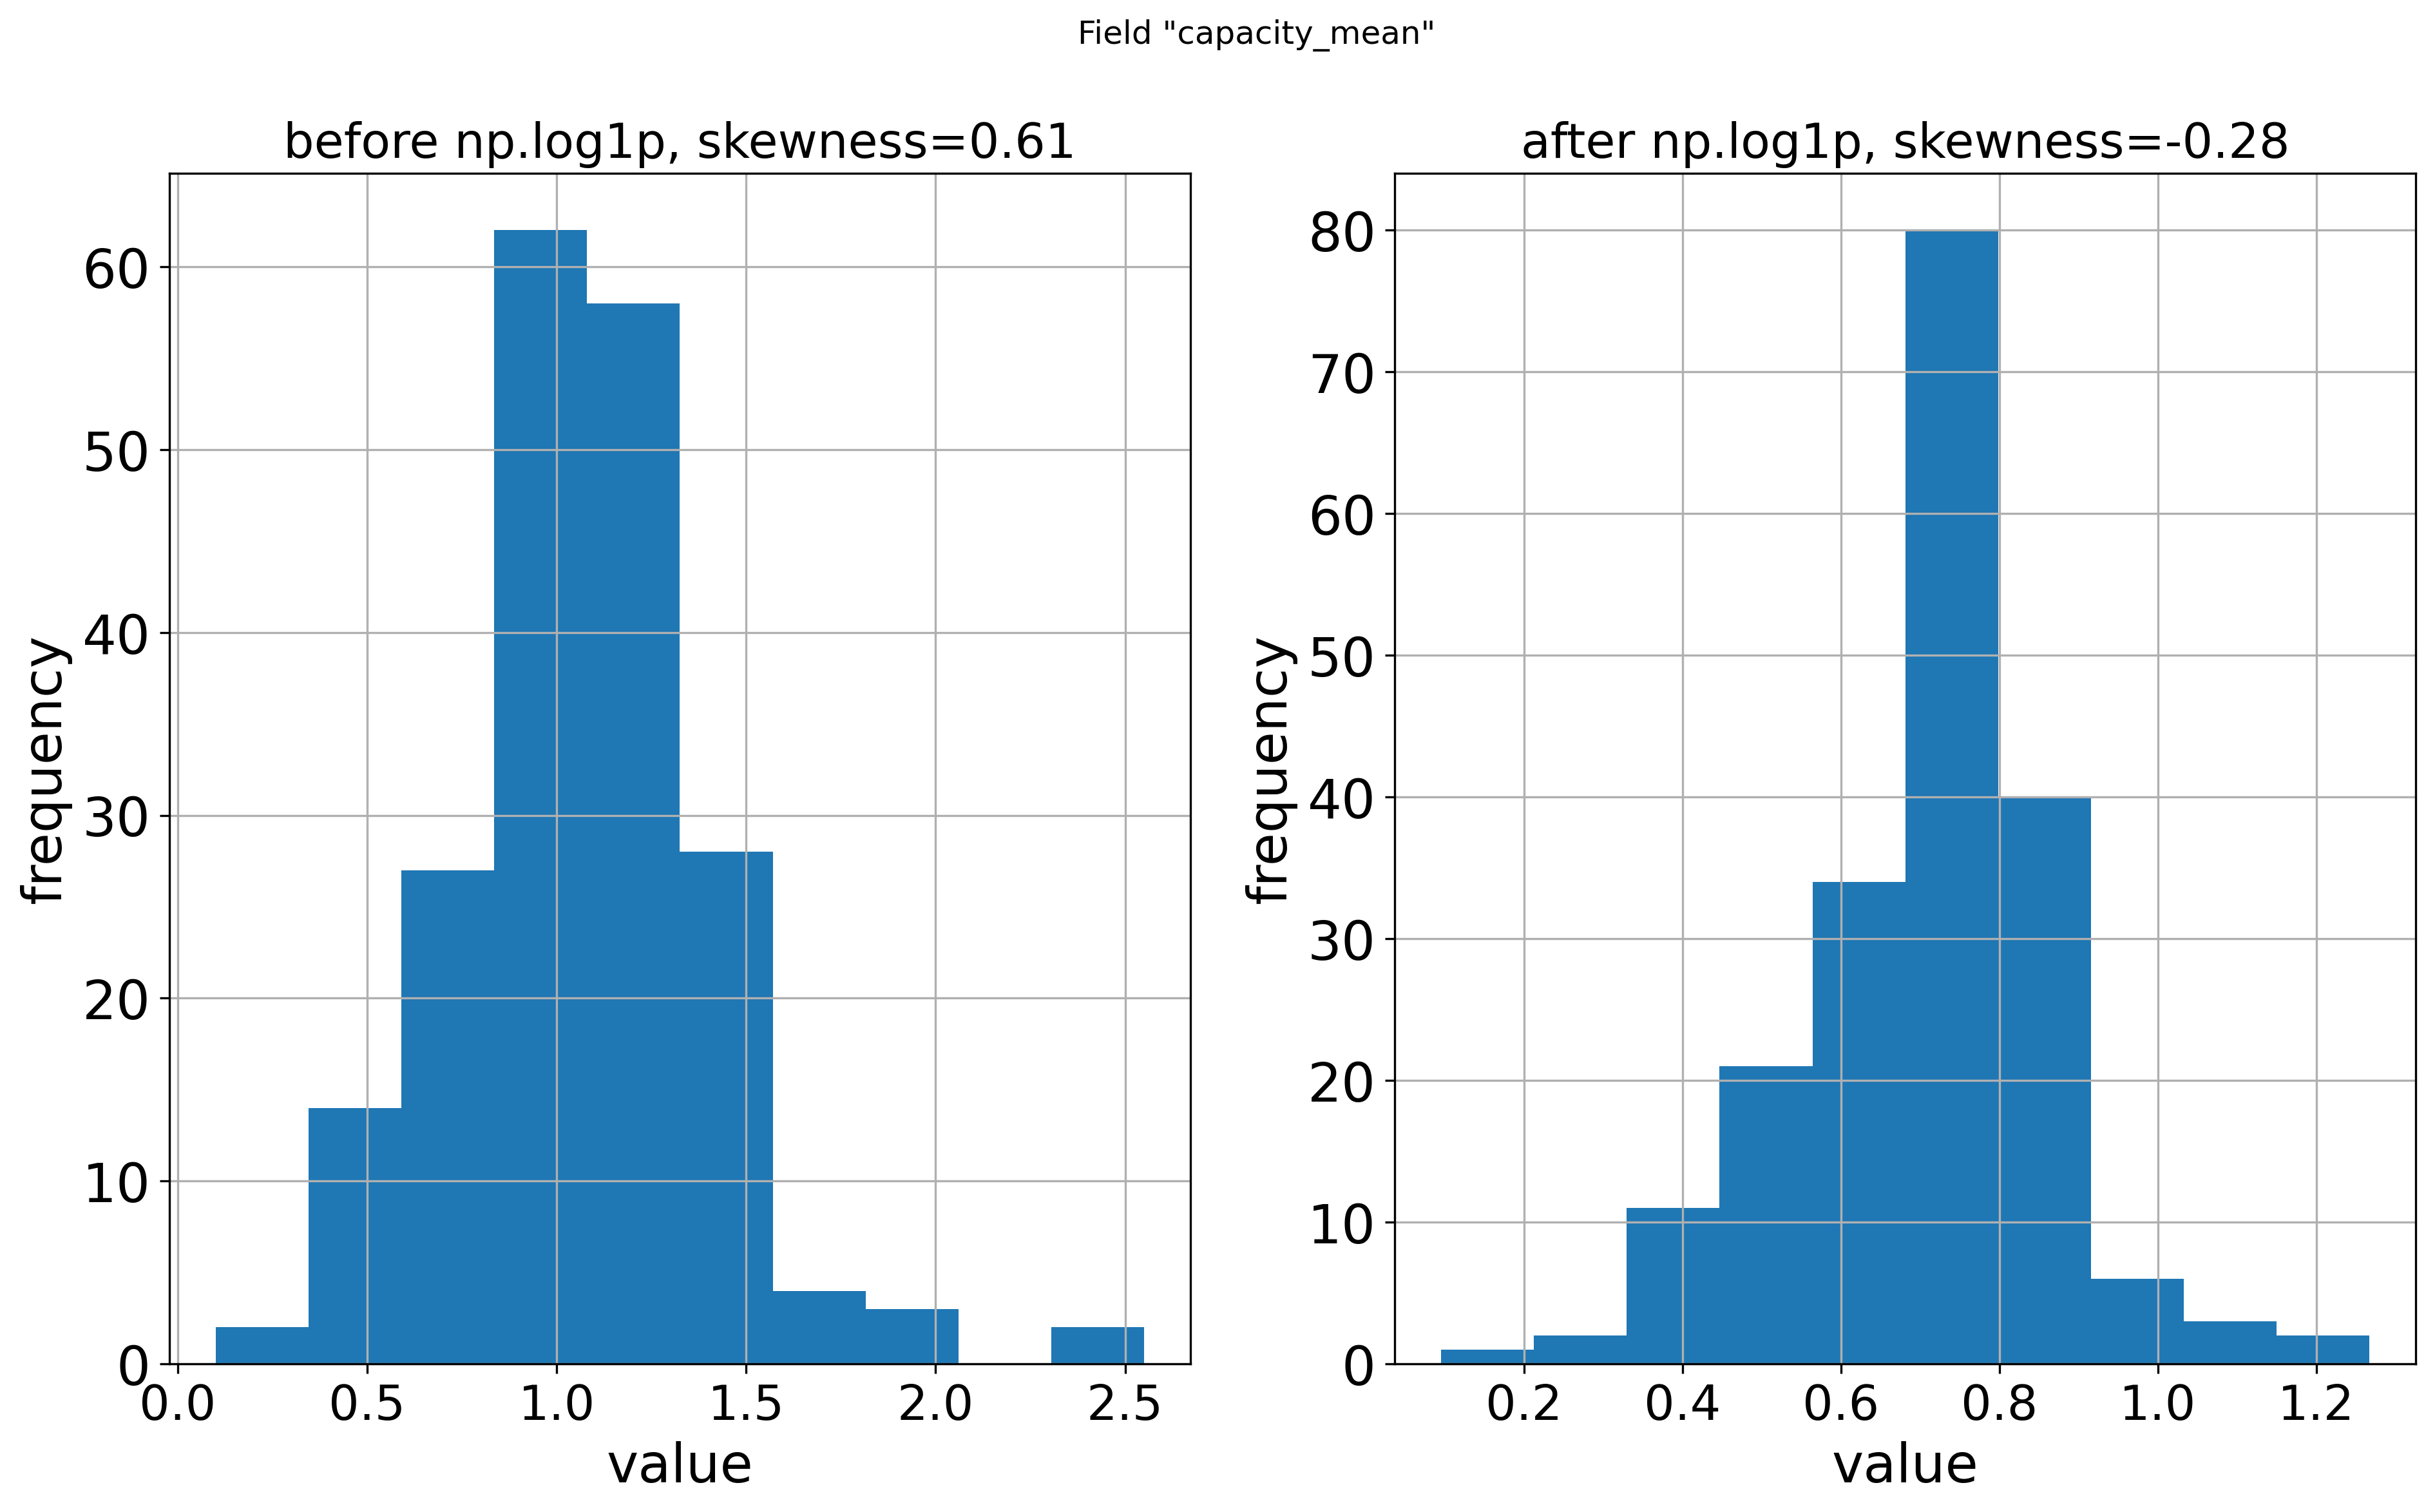

In [12]:
# Let's look at what happens to one of these features, when we apply np.log visually.

# Choose a field
#field = "Capacity change (Fold increase compared to WT control)"
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(15, 8))

# Create a histogram on the "ax_before" subplot
all_data[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
all_data[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
title_before = 'before np.log1p'

ax_before.set(title=f'before np.log1p, skewness={skew_vals1:.2}', ylabel='frequency', xlabel='value')
ax_after.set(title=f'after np.log1p, skewness={skew_vals2:.2}', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));


### check the rows with the largest std

In [13]:
overexpress_data = all_data
overexpress_data[overexpress_data['capacity_std']>0.5]

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Pex30,Pex31,Pex32,Pex34,Sei1,Rtn1,Vps1,capacity_mean,capacity_std,capacity_instances
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.385,0.5303,"(1.76, 1.01)"
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.395,0.5586,"(1.79, 1.0)"


In [14]:
max(overexpress_data.iloc[:,-3])

2.55

In [14]:
num_classes=1
gene_num=25

In [17]:
## One hot encoding with "channel"
Y = np.log1p(overexpress_data.iloc[:, -3])
Y.shape

(200,)

In [18]:
## train_test_split
rs=42
X = overexpress_data.iloc[:,:-3]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=rs)

In [20]:
test_results = {}

## Gradient Boosting Regression

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt_model=GradientBoostingRegressor(random_state=42)
gbrt_model.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [22]:
y_pred_train = gbrt_model.predict(X_train)
y_pred_test = gbrt_model.predict(X_test)
test_results['GBRT'] = metrics.mean_squared_error(Y_test, y_pred_test)

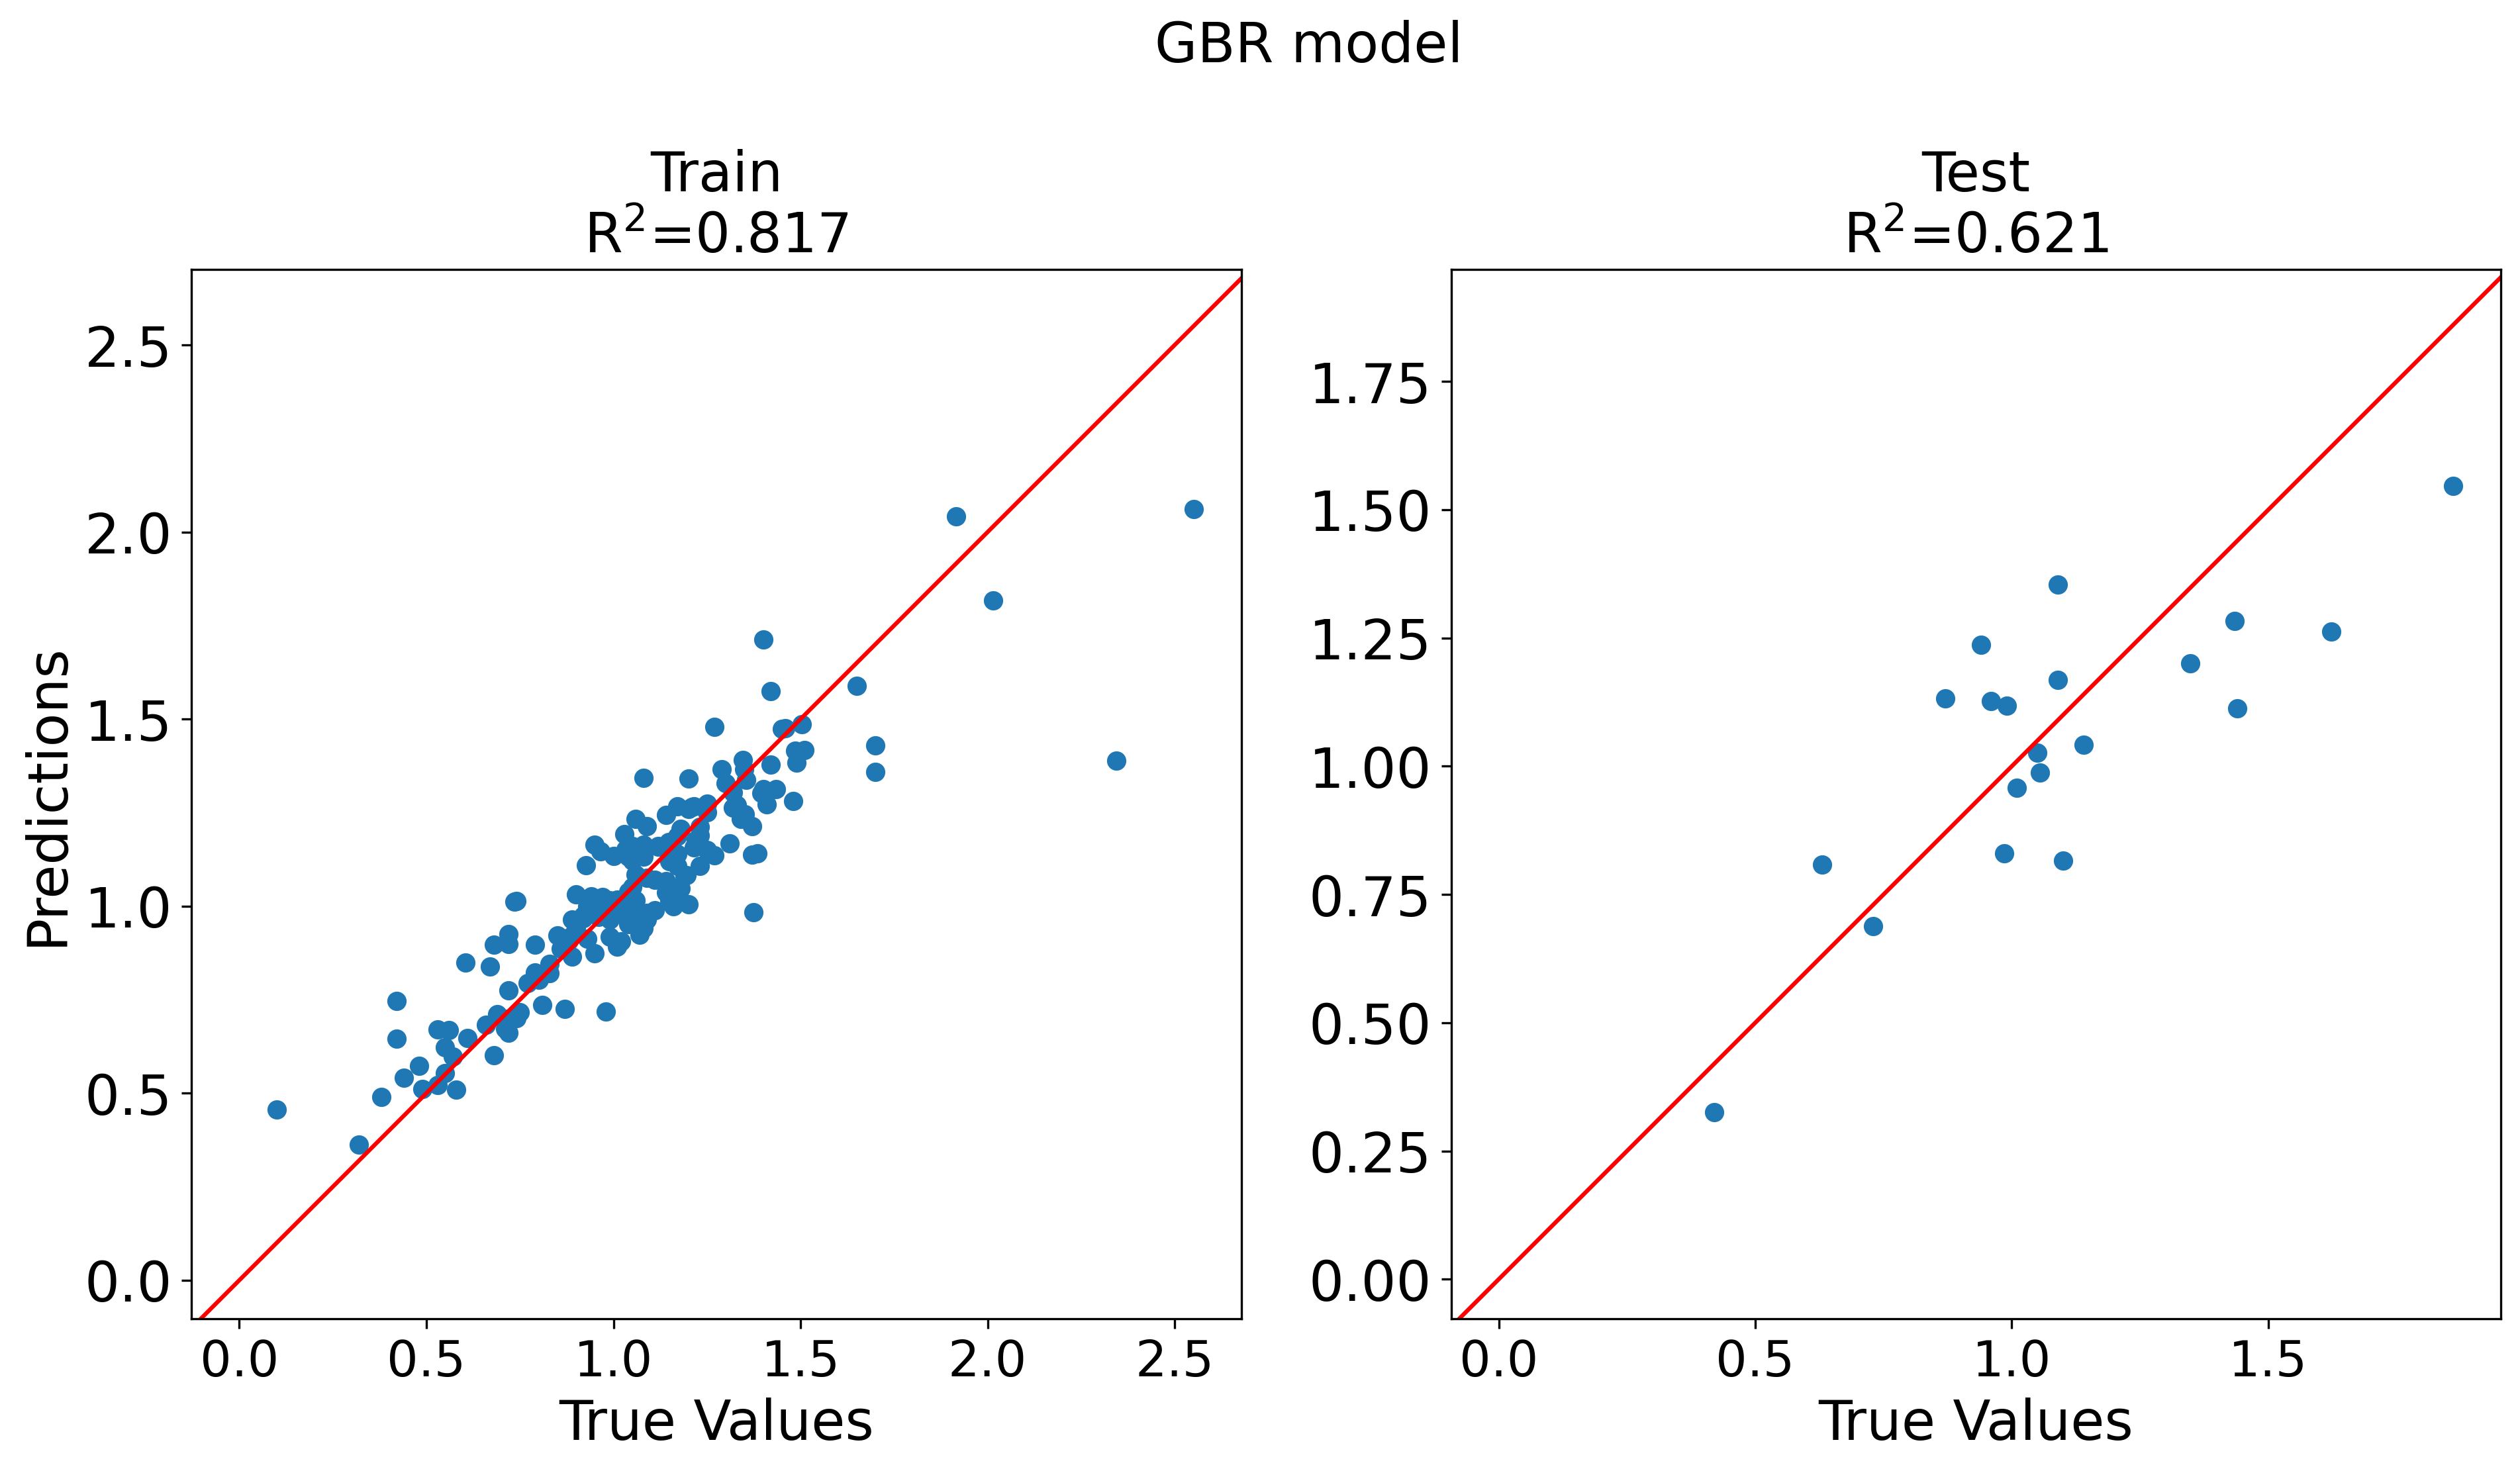

In [23]:
model_name = "GBR model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [60]:
## save the model
#with open('save_ML/gbrt_model_05152023_boost.pkl','wb') as f:
#    pickle.dump(gbrt_model,f)

In [124]:
gbrt_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 22,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### GridSearchCV--search for the optimal hyperparameters 

In [28]:
param_grid = [{'max_depth': [2, 3, 4], 'learning_rate':[0.1, 0.15, 0.2], 'n_estimators': [100, 150, 200]}]
    
gbrt=GradientBoostingRegressor(random_state=42)
    
gbrt_grid = GridSearchCV(gbrt, param_grid, cv=3, verbose=1)
best_model=gbrt_grid.fit(X_train, Y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [29]:
best_model.best_params_
#{'max_depth': 6,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 150}

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [30]:
gbrt_best = GradientBoostingRegressor(**best_model.best_params_)
gbrt_best.fit(X_train, Y_train)



GradientBoostingRegressor()

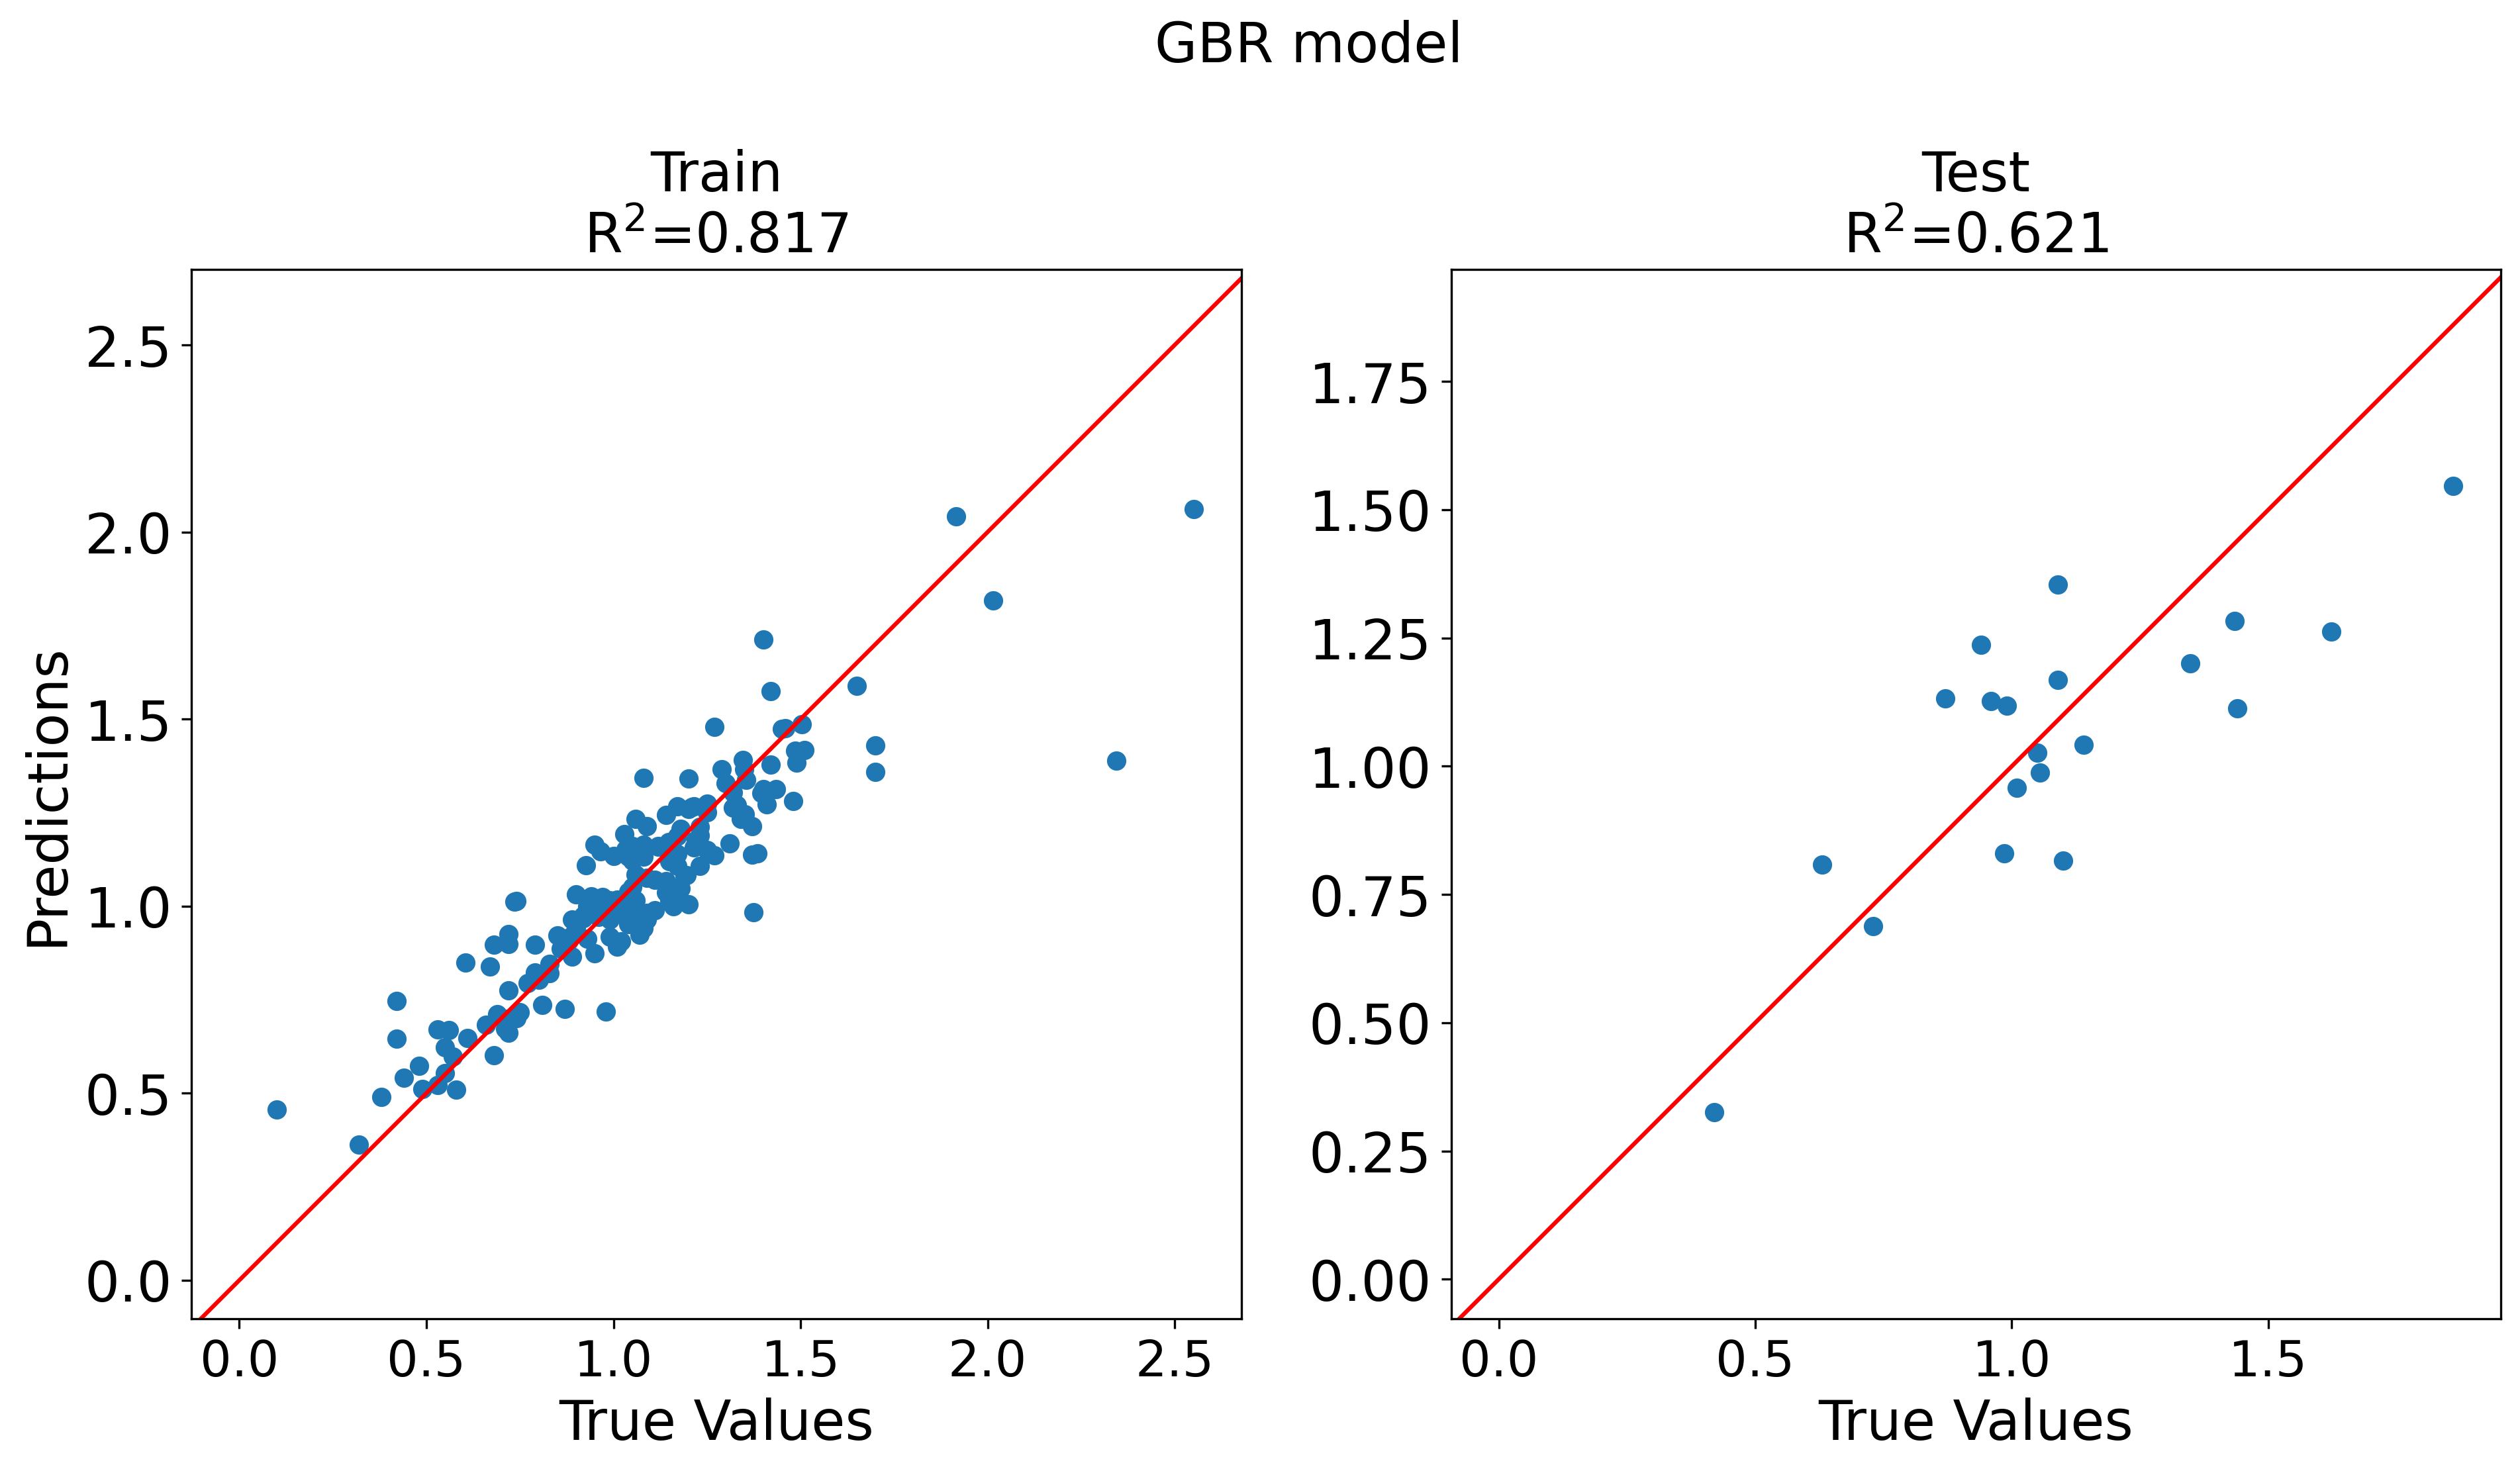

In [31]:
y_pred_train = gbrt_best.predict(X_train)
y_pred_test = gbrt_best.predict(X_test)
#test_results['GBRT'] = metrics.mean_squared_error(Y_test, y_pred_test)

model_name = "GBR model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [28]:
with open('save_ML/gbrt_model_05152023_new_tuning_sw.pkl','wb') as f:
    pickle.dump(gbrt_model,f)

## Deep Neural Network 

## CNN+LSTM

In [20]:
output_dim=1
batch_size=20
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
#input_position=Input(shape=(gene_num, num_classes), name='input_position')
input_position = Input(shape=(gene_num,), name='input_position')
reshaped_input = Reshape((gene_num, num_classes))(input_position)
#initializer = HeNormal(seed=42)#kernel_initializer=initializer, 
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(reshaped_input)
x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
x = Dense(16*output_dim, activation='relu')(x)
x = Dropout(0.3)(x)

z = Dense(output_dim)(x)
model_cnn_lstm = keras.Model(inputs=input_position,outputs=z)
model_cnn_lstm.summary()


2024-04-23 21:36:00.001165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31010 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2024-04-23 21:36:00.004139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31010 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2024-04-23 21:36:00.006870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31010 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0004:06:00.0, compute capability: 7.0
2024-04-23 21:36:00.009512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31010 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_position (InputLayer)  [(None, 25)]             0         
                                                                 
 reshape (Reshape)           (None, 25, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 25, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            784       
                                                                 
 lstm (LSTM)                 (None, 25, 4)             336       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16)                1616  

In [ ]:
#### Compile the model
model_cnn_lstm.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=5e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

#history = model_cnn_lstm.fit(X_train_channel, Y_train, batch_size=batch_size,  epochs=1200,validation_data=(X_test_channel,Y_test), 
#                             callbacks=[keras.callbacks.EarlyStopping(patience=400)], verbose=1)

history = model_cnn_lstm.fit(X_train, Y_train, batch_size=batch_size,  epochs=900)#,validation_data=(X_test,Y_test)) 
#                             callbacks=[keras.callbacks.EarlyStopping(patience=400)], verbose=1)
#validation_data=(X_test_channel, y_test),


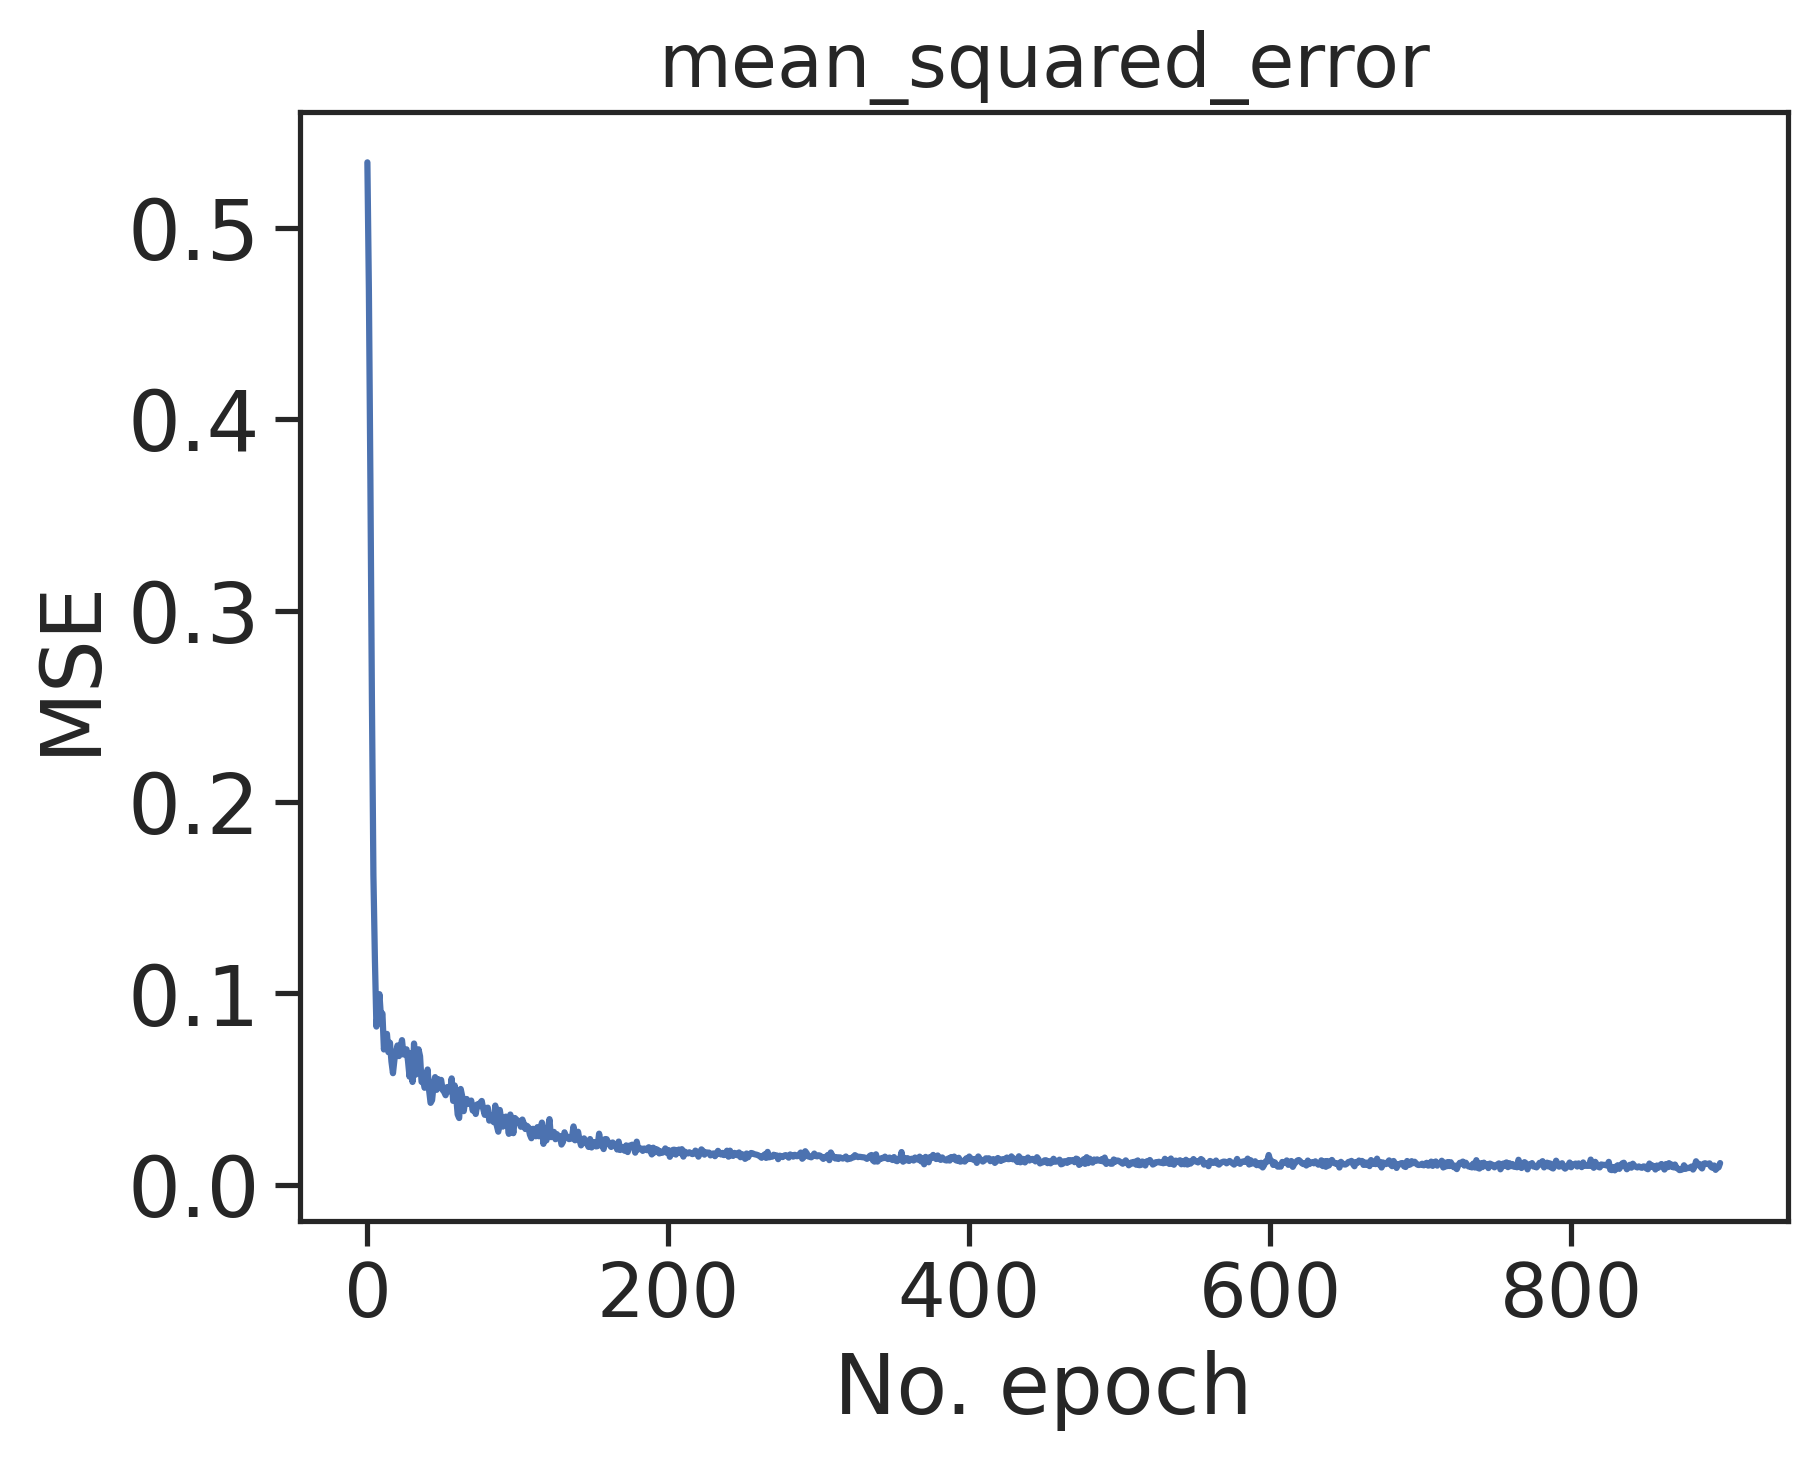

In [38]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
#plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [39]:
y_pred_train = model_cnn_lstm.predict(X_train)
y_pred_test = model_cnn_lstm.predict(X_test)
#test_results['CNN_LSTM_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

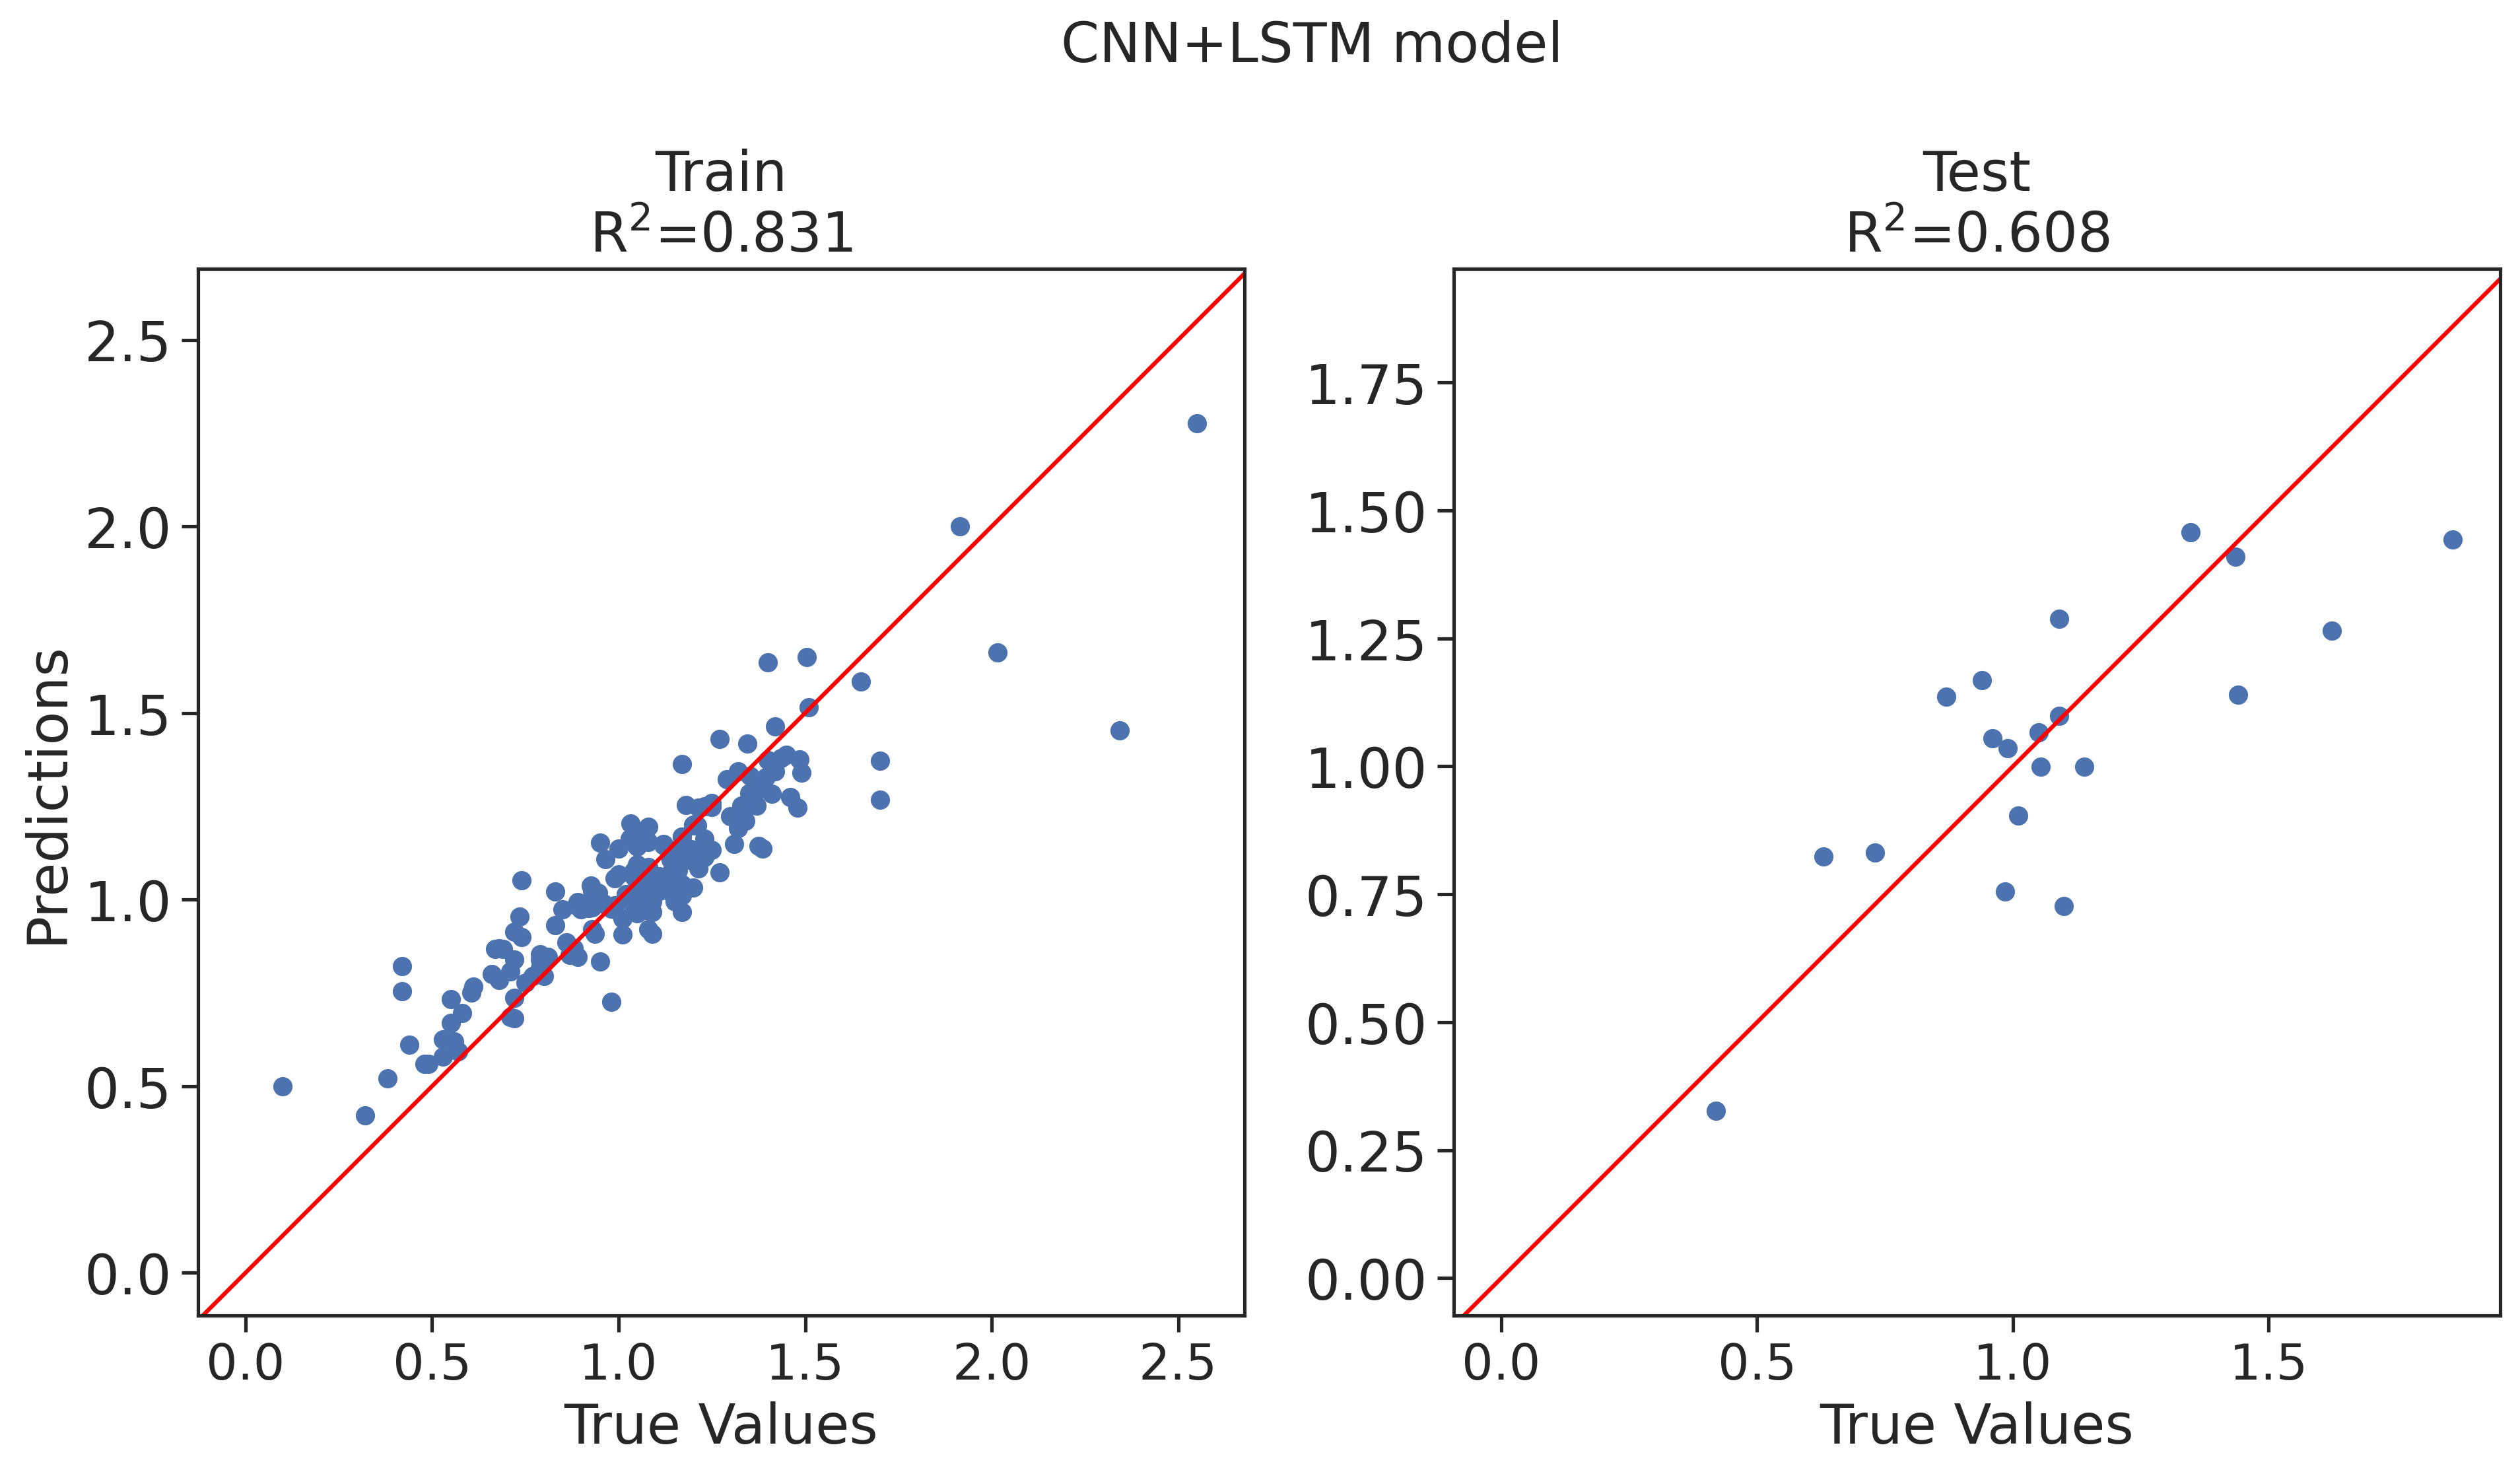

In [40]:
model_name = "CNN+LSTM model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

## CNN+LSTM grid searching

In [21]:
def build_cnn_lstm_model(conv_layers=2,filters=16,kernel_size=3, lstm_units=4, lstm_dropout=0.3, dense_units=16, dense_dropout=0.3, learning_rate=5e-4):
    input_position = Input(shape=(gene_num,), name='input_position')
    reshaped_input = Reshape((gene_num, num_classes))(input_position)
    x = reshaped_input
    ## add conv_layers number of Conv1D layers
    for _ in range(conv_layers):
        x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout)(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dense_dropout)(x)
    z = Dense(1)(x) 
    model = keras.Model(inputs=input_position, outputs=z)
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model



In [42]:
# KerasRegressor is deprecated, use Sci-Keras
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping


model_cnn_lstm_grid = KerasRegressor(model=build_cnn_lstm_model, 
                                     conv_layers=2,
                                     filters=16,
                                     kernel_size=3, 
                                     lstm_units=4, 
                                     lstm_dropout=0.3, 
                                     dense_units=16, 
                                     dense_dropout=0.3, 
                                     learning_rate=5e-4,
                                     epochs=900, batch_size=20, verbose=1) ## model parameter is needed

# full param grid:
param_grid = {
    'conv_layers': [1,2,3],
    'filters': [8, 16, 32], 
    'kernel_size': [1, 3, 5],
    'lstm_units': [2, 4, 8], # LSTM units
    'dense_units': [8, 16, 32], # Dense layer units
    'learning_rate': [5e-4, 1e-3, 2e-3], # Learning rate
}


#cnn_lstm_grid = GridSearchCV(estimator=model_cnn_lstm_grid, param_grid=param_grid, cv=2,scoring=new_score,verbose=1)  # verbose 
cnn_lstm_grid = GridSearchCV(estimator=model_cnn_lstm_grid, param_grid=param_grid, cv=3,verbose=0)  # verbose 


In [ ]:
cnn_lstm_hist = cnn_lstm_grid.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                      callbacks=[EarlyStopping(patience=90)],verbose=0)


In [46]:
# Best parameters found
print("Best: %f using %s" % (cnn_lstm_hist.best_score_, cnn_lstm_hist.best_params_))

Best: 0.394669 using {'conv_layers': 2, 'dense_units': 16, 'filters': 8, 'kernel_size': 5, 'learning_rate': 0.001}


In [22]:
best_params=  {'conv_layers': 2, 'dense_units': 16, 'filters': 8, 'kernel_size': 5, 'learning_rate': 0.001}

In [ ]:
# use build_cnn_lstm_model
#model_cnn_lstm_best = build_cnn_lstm_model(**cnn_lstm_hist.best_params_)
model_cnn_lstm_best = build_cnn_lstm_model(**best_params)
history = model_cnn_lstm_best.fit(X_train, Y_train, batch_size=batch_size,  epochs=400,verbose=1)

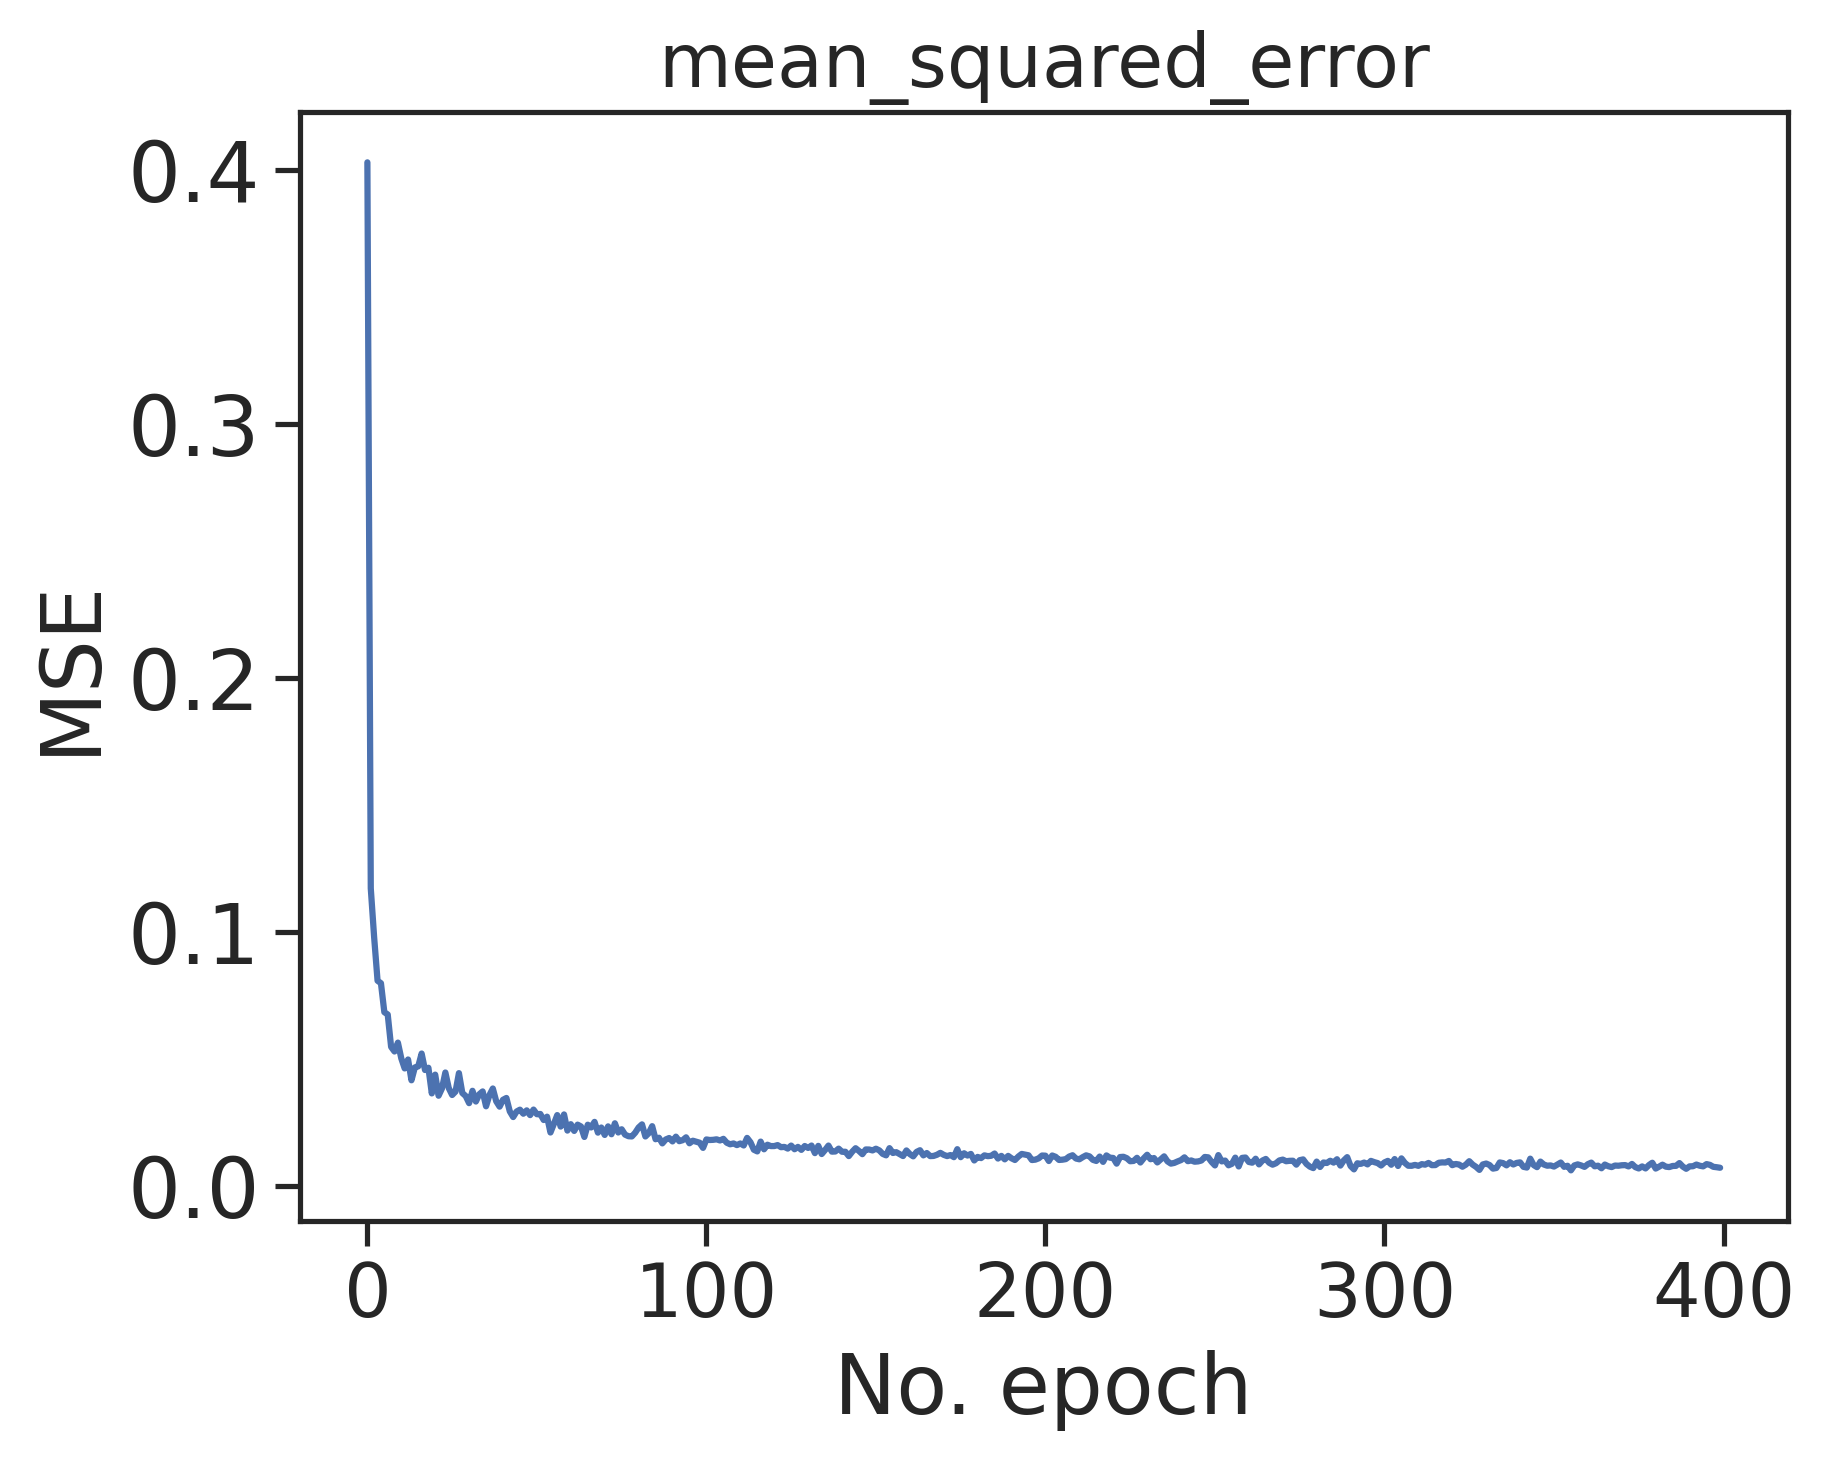

In [28]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
#plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [29]:
y_pred_train = model_cnn_lstm_best.predict(X_train)
y_pred_test = model_cnn_lstm_best.predict(X_test)
test_results['CNN_LSTM_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

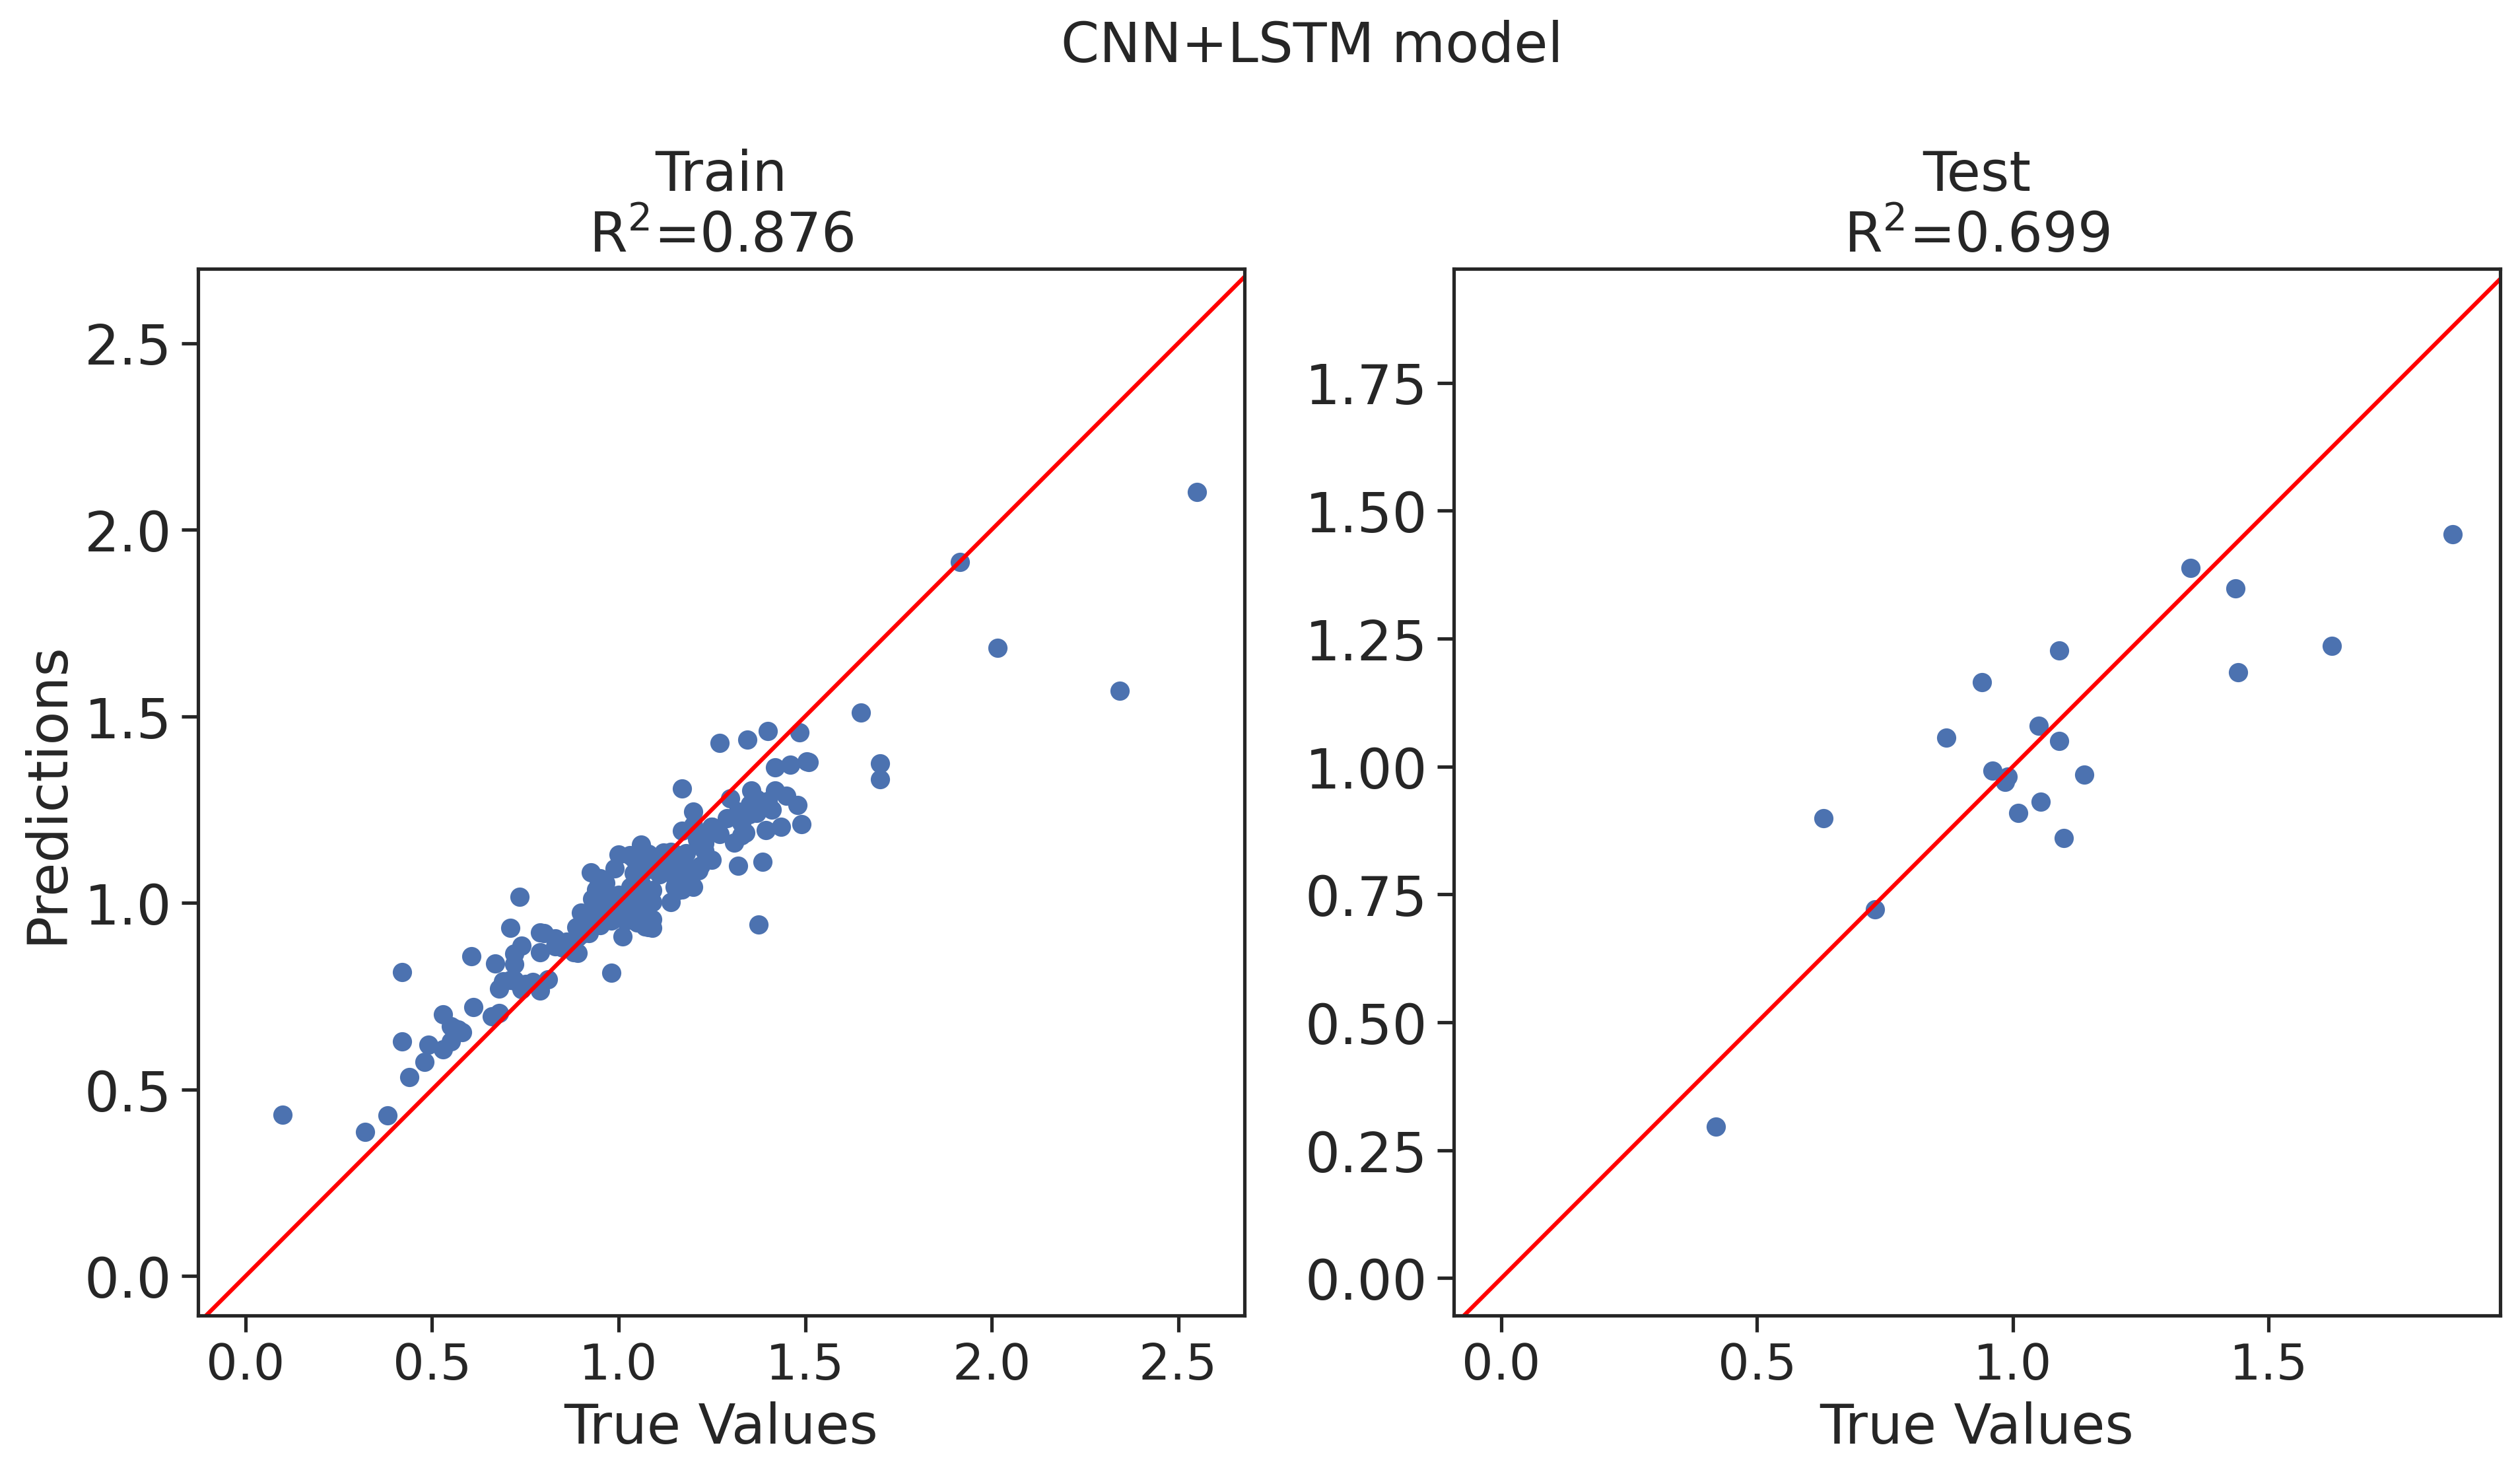

In [30]:
model_name = "CNN+LSTM model"

plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [37]:
#save model
model_cnn_lstm_best.save('save_ML/CNN+LSTM_model_05152023_tuning.h5')